In [3]:
!pip install transformers
!pip install arabic-stopwords
!pip install nlpaug
!pip install tashaphyne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 33.6 MB/s 
     |████████████████████████████████| 7.6 MB 59.6 MB/s 
     |████████████████████████████████| 182 kB 76.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 353 kB 38.7 MB/s 
     |████████████████████████████████| 126 kB 73.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 410 kB 33.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 251 kB 39.1 MB/s 


In [4]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
import spacy
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from tqdm.auto import tqdm
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import classification_report
import random
from termcolor import colored


import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Embedding, Flatten, Dense
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from keras.layers import Dense, Bidirectional, Embedding, LSTM


import random 
import transformers
from transformers import  AutoModel,AutoTokenizer
import arabicstopwords.arabicstopwords as ast
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
nltk.download('punkt')
from sklearn.model_selection import train_test_split
import pickle
from nltk.corpus import stopwords
from textblob import TextBlob
import re
from tashaphyne.stemming import ArabicLightStemmer
from nltk.stem.isri import ISRIStemmer


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
data = pd.read_csv("/content/Names_data_all.csv")
data

,Name,Label
0,إحتفاظ دتاس روحان,1
1,آدذ رضين عرندس,0
2,لشولق عارف سراج,1
3,آر خزو اكز,0
4,ُبى ريم بدالوهّاب,1
...,...,...
24627,يقظاة نشي اهر,0
24628,فرحون اليف ضرغام,1
24629,يوخاوخة ضاردط رؤوحخ,0
24630,فريد عبدالحي نظام,1


In [6]:
import pyarabic.araby as araby


In [7]:
ArListem = ArabicLightStemmer()

def stem(text):
    zen = TextBlob(text)
    words = zen.words
    cleaned = list()
    for w in words:
        ArListem.light_stem(w)
        cleaned.append(ArListem.get_root())
    return " ".join(cleaned)

import pyarabic.araby as araby
def normalizeArabic(text):
    text = text.strip()
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    noise = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(noise, '', text)
    text = re.sub(r'(.)\1+', r"\1\1", text) # Remove longation
    return araby.strip_tashkeel(text)

In [8]:
def clean_text(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)  
    ## Convert text to lowercases
    text = text.lower()
    ## Remove numbers
    text = re.sub("\d+", " ", text)
    ## Remove Tashkeel
    text = normalizeArabic(text)
    #text = re.sub('\W+', ' ', text)
    text = re.sub('[A-Za-z]+',' ',text)
    text = re.sub(r'\\u[A-Za-z0-9\\]+',' ',text)
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)  
    #Stemming
    text = stem(text)
    return text



In [9]:
df = data['Name'].apply(lambda x:clean_text(x))
df

0            حتفظ دوس رحو
1           ودذ رضن عرندس
2             شلق عرف روج
3               ر خزز وكز
4             بي ريم دلهب
               ...       
24627         يقظ نشش وهر
24628        فرح ليف ضرغم
24629       خخه ضردط رءحخ
24630       فرد عبدلح نظم
24631    مصع عبدنفنفه عفف
Name: Name, Length: 24632, dtype: object

In [10]:
max_len = max([len(t) for t in df])
max_len

26

In [11]:
x_train, x_val ,y_train ,y_val = train_test_split(df,data.Label,test_size=0.3,shuffle=True)
x_val, x_test , y_val, y_test= train_test_split(x_val,y_val, test_size=0.5, random_state=42,shuffle=True)

In [12]:
x_train.shape

(17242,)

In [13]:
tokenizer = Tokenizer(oov_token="oov")
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

In [14]:
tokenizer_seq_train = tokenizer.texts_to_sequences(x_train)
tokenized_seq_val = tokenizer.texts_to_sequences(x_val)
tokenized_seq_test = tokenizer.texts_to_sequences(x_test)


y_train = np.asarray(y_train).astype('float32')
y_val = np.asarray(y_val).astype('float32')
y_test = np.asarray(y_test).astype('float32')


tokenizer_seq_train = pad_sequences(tokenizer_seq_train, maxlen=max_len, padding='post',truncating='post')
tokenized_seq_val = pad_sequences(tokenized_seq_val, maxlen=max_len, padding='post', truncating='post')
tokenized_seq_test = pad_sequences(tokenized_seq_test, maxlen=max_len, padding='post', truncating='post')

In [15]:
print(tokenizer_seq_train.shape)
print(tokenized_seq_val.shape)

(17242, 26)
(3695, 26)


In [16]:
y_train.shape

(17242,)

In [17]:
y_train

array([1., 1., 0., ..., 0., 1., 1.], dtype=float32)

In [18]:
x_train

7156      حكو عبدلغفر ضبر
16688         زكء كنع ذلق
4825          ظطف عرر ضصخ
24288         عول ثمم رضو
1474          ريع كنز سطح
               ...       
18711    جهزد ءسحبءق ثطثم
8488      فتن مرن عبدلجبر
21117         جير غدد رشد
4012          ذءع ليغ نبي
11058         رجء غتن حتم
Name: Name, Length: 17242, dtype: object

In [19]:
len(tokenizer.word_index)

11370

In [20]:
max_vocab = len(tokenizer.word_index)
max_vocab

11370

# Bidirection_LSTM

In [75]:
# embedding_size = len(tokenizer.word_index)
# vocab_sz = 200
# model = Sequential()
# model.add(Embedding(vocab_sz+1, embedding_size, mask_zero=True, input_length=max_len))
# model.add(Bidirectional(LSTM(128, return_sequences=True, dropout = 0.5)))
# model.add(Bidirectional(LSTM(64,return_sequences=True, dropout = 0.4)))
# model.add(Bidirectional(LSTM(16, dropout = 0.3)))
# model.add(Dense(8, activation='relu'))
# model.add(Dense(1, activation = 'sigmoid'))

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# model.summary()


model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 32)          359392    
                                                                 
 bidirectional_5 (Bidirectio  (None, None, 128)        49664     
 nal)                                                            
                                                                 
 bidirectional_6 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                

In [76]:
# We are going to use early stop, which stops when the validation loss no longer improve.
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(tokenizer_seq_train, y_train, 
                    epochs=15,validation_split=0.1, 
                    batch_size=128, shuffle=True, 
                    callbacks=[early_stop],
                    validation_data = (tokenized_seq_val, y_val))

Epoch 1/15


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


135/135 [==============================] - 9s 23ms/step - loss: 0.6931 - accuracy: 0.5100 - val_loss: 0.6922 - val_accuracy: 0.5088
Epoch 2/15
135/135 [==============================] - 2s 12ms/step - loss: 0.6912 - accuracy: 0.5687 - val_loss: 0.6865 - val_accuracy: 0.7886
Epoch 3/15
135/135 [==============================] - 2s 16ms/step - loss: 0.5296 - accuracy: 0.8008 - val_loss: 0.3764 - val_accuracy: 0.8382
Epoch 4/15
135/135 [==============================] - 2s 15ms/step - loss: 0.2986 - accuracy: 0.8855 - val_loss: 0.3042 - val_accuracy: 0.8804
Epoch 5/15
135/135 [==============================] - 2s 12ms/step - loss: 0.2338 - accuracy: 0.9174 - val_loss: 0.2777 - val_accuracy: 0.8888
Epoch 6/15
135/135 [==============================] - 2s 12ms/step - loss: 0.2045 - accuracy: 0.9322 - val_loss: 0.2681 - val_accuracy: 0.8942
Epoch 7/15
135/135 [==============================] - 2s 12ms/step - loss: 0.1818 - accuracy: 0.9422 - val_loss: 0.2673 - val_accuracy: 0.8969
Epoch 8/15

In [77]:
loss, accuracy = model.evaluate(tokenized_seq_test, y_test)
print('Accuracy: %f' % (accuracy*100))

116/116 [==============================] - 1s 5ms/step - loss: 0.2928 - accuracy: 0.8877
Accuracy: 88.768607


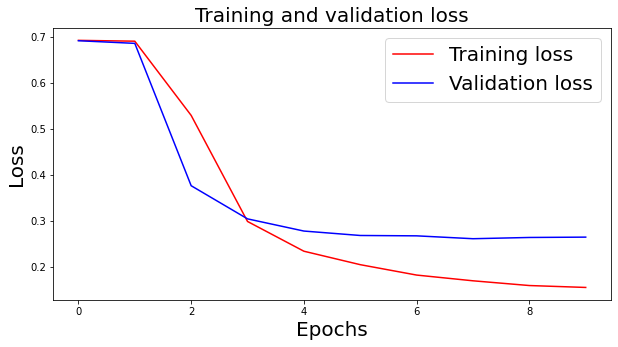

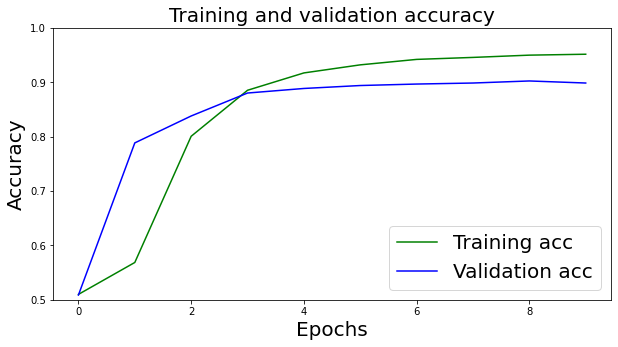

In [78]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(10,5))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(10,5))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

# LSTM

In [79]:
model_lstm = tf.keras.Sequential([
        tf.keras.layers.Embedding(max_vocab, 100, input_length=max_len),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(1, activation='sigmoid')
])

In [80]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model_lstm.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer="adam",
              metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 26, 100)           1123100   
                                                                 
 bidirectional_7 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,157,213
Trainable params: 1,157,213
Non-trainable params: 0
_________________________________________________________________


In [81]:
history = model_lstm.fit(tokenizer_seq_train, y_train, 
                    epochs=30,validation_split=0.1, 
                    batch_size=128, shuffle=True, 
                    callbacks=[early_stop],
                    validation_data = (tokenized_seq_val, y_val))

Epoch 1/30
135/135 [==============================] - 5s 14ms/step - loss: 0.5589 - accuracy: 0.7253 - val_loss: 0.3483 - val_accuracy: 0.8579
Epoch 2/30
135/135 [==============================] - 1s 8ms/step - loss: 0.2428 - accuracy: 0.9079 - val_loss: 0.2427 - val_accuracy: 0.9164
Epoch 3/30
135/135 [==============================] - 1s 8ms/step - loss: 0.1774 - accuracy: 0.9404 - val_loss: 0.2240 - val_accuracy: 0.9188
Epoch 4/30
135/135 [==============================] - 1s 8ms/step - loss: 0.1589 - accuracy: 0.9450 - val_loss: 0.2370 - val_accuracy: 0.9083
Epoch 5/30
135/135 [==============================] - 1s 8ms/step - loss: 0.1531 - accuracy: 0.9472 - val_loss: 0.2280 - val_accuracy: 0.9142


In [82]:
loss, accuracy = model_lstm.evaluate(tokenized_seq_test, y_test)
print('Accuracy: %f' % (accuracy*100))

116/116 [==============================] - 0s 4ms/step - loss: 0.2566 - accuracy: 0.8980
Accuracy: 89.797026


# GRU

In [21]:
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(800, 100, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.00003 
model_gru.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate),
                  metrics=['accuracy'])

model_gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 26, 100)           80000     
                                                                 
 bidirectional (Bidirectiona  (None, 64)               25728     
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 105,793
Trainable params: 105,793
Non-trainable params: 0
_________________________________________________________________


In [22]:
model_gru.fit(tokenizer_seq_train, y_train, epochs=10, validation_data=(tokenized_seq_val, y_val))

Epoch 1/10
539/539 [==============================] - 15s 15ms/step - loss: 0.6924 - accuracy: 0.5767 - val_loss: 0.6876 - val_accuracy: 0.6836
Epoch 2/10
539/539 [==============================] - 7s 14ms/step - loss: 0.6885 - accuracy: 0.6948 - val_loss: 0.6827 - val_accuracy: 0.7813
Epoch 3/10
539/539 [==============================] - 7s 14ms/step - loss: 0.6796 - accuracy: 0.7670 - val_loss: 0.6702 - val_accuracy: 0.7970
Epoch 4/10
539/539 [==============================] - 7s 12ms/step - loss: 0.6566 - accuracy: 0.7943 - val_loss: 0.6382 - val_accuracy: 0.7943
Epoch 5/10
539/539 [==============================] - 6s 12ms/step - loss: 0.6055 - accuracy: 0.8048 - val_loss: 0.5778 - val_accuracy: 0.7981
Epoch 6/10
539/539 [==============================] - 5s 8ms/step - loss: 0.5350 - accuracy: 0.8091 - val_loss: 0.5150 - val_accuracy: 0.7949
Epoch 7/10
539/539 [==============================] - 4s 7ms/step - loss: 0.4732 - accuracy: 0.8121 - val_loss: 0.4712 - val_accuracy: 0.7981


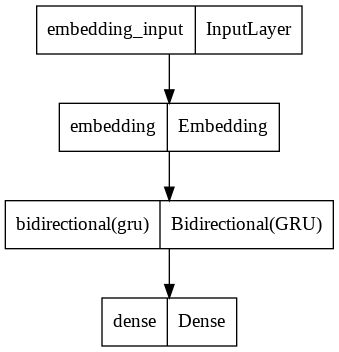

In [23]:
from tensorflow.keras.utils import plot_model
plot_model(model_gru)

# Evaluate

In [111]:
Name1 = ['احمد اسلام عوض']
Name2 = ['باسم وحيد السيد']
Name3 = ['باسم يبلي سيلبس']


In [115]:
# df_test = pd.DataFrame(Names)
testing = []
print(Name1) 

# preprocess the sequences
testing.append(clean_text(Name1[0]))

# Create the sequences
padding_type='post'
sample_sequences = tokenizer.texts_to_sequences(testing)
fakes_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=max_len)                      
print(fakes_padded)
classes = model.predict(fakes_padded)

# The closer the class is to 1, the more positive the review is deemed to be
print(Name1)
print(f'Confidence Score :{classes[0][0]}')
print('\n')

['احمد اسلام عوض']
[[ 2 25  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]]
1/1 [==============================] - 0s 19ms/step
['احمد اسلام عوض']
Confidence Score :0.7284524440765381




# 

In [105]:
# df_test = pd.DataFrame(Names)
testing = []
print(Name2) 

# preprocess the sequences
testing.append(clean_text(Name2[0]))

# Create the sequences
padding_type='post'
sample_sequences = tokenizer.texts_to_sequences(testing)
fakes_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=max_len)                      

classes = model_gru.predict(fakes_padded)

# The closer the class is to 1, the more positive the review is deemed to be
print(Name2)
print(f'Confidence Score :{classes[0][0]}')
print('\n')

['باسم وحيد السيد']
1/1 [==============================] - 0s 19ms/step
['باسم وحيد السيد']
Confidence Score :0.7054824829101562




In [114]:
# df_test = pd.DataFrame(Names)
testing = []
print(Name3) 

# preprocess the sequences
testing.append(clean_text(Name3[0]))

# Create the sequences
padding_type='post'
sample_sequences = tokenizer.texts_to_sequences(testing)
fakes_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=max_len)                      
classes = model_gru.predict(fakes_padded)

# The closer the class is to 1, the more positive the review is deemed to be
print(Name3)
print(f'Confidence Score :{classes[0][0]}')
print('\n')

['باسم يبلي سيلبس']
1/1 [==============================] - 0s 19ms/step
['باسم يبلي سيلبس']
Confidence Score :0.3801479637622833




# Saving the model

In [96]:
from keras.models import load_model
model_gru.save("network.h5")

In [107]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

In [ ]:
# import pickle

# filename = 'RealFakeName_model.sav'
# pickle.dump(model_gru, open(filename, 'wb'))

In [ ]:
# from joblib import Parallel, delayed
# import joblib
  
  
# # Save the model as a pickle in a file
# joblib.dump(model, 'RealFakeName_model.pkl')

In [ ]:
# joblib.dump(model_lstm, 'RealFakeName_model_LSTM.pkl')

In [95]:
# import time
# t = time.time()

# export_path_keras = "/content/gdrive/MyDrive/model/{}.h5".format(int(t))
# print(export_path_keras)

# model_gru.save(export_path_keras)

/content/gdrive/MyDrive/model/1670731988.h5
